# Assignment 4: Text and Sequence Data - IMDB Sentiment Analysis

**Author:** Divya Ratakonda


## 1. Setup and Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob


np.random.seed(42)


import warnings
warnings.filterwarnings('ignore')


os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras.datasets import imdb
from keras.utils import pad_sequences



## 2. Configuration

In [2]:

MAX_FEATURES = 10000   # Top 10,000 words
MAX_LEN = 150          # Cutoff reviews after 150 words
VAL_SAMPLES = 10000    # Validate on 10,000 samples
EMBEDDING_DIM = 100    # GloVe 6B: 50, 100, 200, 300 (NO 128!)
HIDDEN_DIM = 64
EPOCHS = 20
BATCH_SIZE = 32

TRAINING_SAMPLE_SIZES = [100, 500, 1000, 2000, 5000, 10000, 15000, 20000]



## 3. IMDB Dataset

In [3]:
# Load IMDB data
(x_train_full, y_train_full), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

print(f"Full training: {len(x_train_full)} samples")
print(f"Test: {len(x_test)} samples")

# Pad sequences
x_train_full = pad_sequences(x_train_full, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

# Split
x_val = x_train_full[:VAL_SAMPLES]
y_val = y_train_full[:VAL_SAMPLES]
x_train_available = x_train_full[VAL_SAMPLES:]
y_train_available = y_train_full[VAL_SAMPLES:]

print(f"\nAfter split:")
print(f"  Training available: {len(x_train_available)}")
print(f"  Validation: {len(x_val)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Full training: 25000 samples
Test: 25000 samples

After split:
  Training available: 15000
  Validation: 10000


## 4. Load GloVe Embeddings



In [4]:
def find_glove_file(embedding_dim):

    filename = f"glove.6B.{embedding_dim}d.txt"


    search_paths = [
        f"./{filename}",
        f"./glove/{filename}",
        Path.home() / f".keras/datasets/{filename}",
        Path.home() / f".keras/datasets/glove/{filename}",
    ]

    print(f"Searching for {filename}...")


    for path in search_paths:
        path = Path(path)
        if path.exists():
            print(f" Found at: {path}")
            return path


    print("Searching recursively...")
    glob_patterns = [
        f"**/{filename}",
    ]

    for pattern in glob_patterns:
        matches = glob.glob(pattern, recursive=True)
        if matches:
            print(f" Found at: {matches[0]}")
            return Path(matches[0])

    return None



In [5]:
def load_glove_embeddings(embedding_dim, max_words):



    print(f"Attempting to download/locate GloVe {embedding_dim}d...")
    try:
        glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
        zip_path = keras.utils.get_file(
            "glove.6B.zip",
            origin=glove_url,
            extract=True,
            cache_dir='.',
            cache_subdir='glove'
        )


        glove_dir = Path(zip_path).parent
        glove_path = glove_dir / f"glove.6B.{embedding_dim}d.txt"

        if glove_path.exists():
            print(f" Found at: {glove_path}")
        else:
            print("Not in expected location, searching...")
            glove_path = find_glove_file(embedding_dim)

            if glove_path is None:
                raise FileNotFoundError(f"Cannot find glove.6B.{embedding_dim}d.txt")

    except Exception as e:
        print(f"Info: {e}")
        print("Searching for existing file...")
        glove_path = find_glove_file(embedding_dim)

        if glove_path is None:
            raise FileNotFoundError(
                f"Could not find glove.6B.{embedding_dim}d.txt\n"
                f"Download from: http://nlp.stanford.edu/data/glove.6B.zip\n"
                f"Extract and place in current directory"
            )

    # Load embeddings
    print(f"Loading embeddings from: {glove_path}")
    embeddings_index = {}

    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Loaded {len(embeddings_index)} word vectors")

    # Create embedding matrix
    embedding_matrix = np.zeros((max_words, embedding_dim))
    word_index_imdb = imdb.get_word_index()
    reverse_word_index = {v: k for k, v in word_index_imdb.items()}

    found_words = 0
    for i in range(1, max_words):
        word = reverse_word_index.get(i)
        if word is not None:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                found_words += 1

    print(f" Mapped {found_words}/{max_words} words ({100*found_words/max_words:.1f}%)")

    return embedding_matrix

print(" GloVe  function defined")

 GloVe  function defined


In [6]:

try:
    embedding_matrix = load_glove_embeddings(EMBEDDING_DIM, MAX_FEATURES)
    glove_available = True
    print("\n GloVe embeddings loaded")
except Exception as e:
    print(f"\n Could not load GloVe: {e}")
    print("Continuing with learned embeddings only")
    glove_available = False

Attempting to download/locate GloVe 100d...
862182613/862182613 ━━━━━━━━━━━━━━━━━━━━ 161s 0us/step
Not in expected location, searching...
Searching for glove.6B.100d.txt...
Searching recursively...
 Found at: glove/glove_extracted/glove.6B.100d.txt
Loading embeddings from: glove/glove_extracted/glove.6B.100d.txt
Loaded 400000 word vectors
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 Mapped 9796/10000 words (98.0%)

 GloVe embeddings loaded


## 5. Define Model Architectures

In [7]:
def build_lstm_learned(max_features, embedding_dim, max_len, hidden_dim):

    inputs = keras.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(max_features, embedding_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="lstm_learned")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_lstm_pretrained(embedding_matrix, max_len, hidden_dim, trainable=False):
    """LSTM with pretrained embeddings."""
    max_features, embedding_dim = embedding_matrix.shape

    inputs = keras.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(
        max_features, embedding_dim,
        weights=[embedding_matrix],
        trainable=trainable,
        mask_zero=True
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="lstm_pretrained")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

print(" Model architectures defined")

 Model architectures defined


## 6. Training Loop

In [8]:
results = []
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

for n_samples in TRAINING_SAMPLE_SIZES:

    print(f"Training with {n_samples} samples")


    if n_samples > len(x_train_available):
        continue

    x_train = x_train_available[:n_samples]
    y_train = y_train_available[:n_samples]

    # Model 1: Learned
    print("\n[1/3] Learned embeddings...")
    model = build_lstm_learned(MAX_FEATURES, EMBEDDING_DIM, MAX_LEN, HIDDEN_DIM)
    model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
              validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
    _, val_acc = model.evaluate(x_val, y_val, verbose=0)
    print(f" Val Acc: {val_acc:.4f}")
    results.append({'n_samples': n_samples, 'model': 'Learned', 'val_accuracy': val_acc})

    if glove_available:
        # Model 2: Pretrained (frozen)
        print("\n[2/3] Pretrained (frozen)...")
        model = build_lstm_pretrained(embedding_matrix, MAX_LEN, HIDDEN_DIM, trainable=False)
        model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                  validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
        _, val_acc = model.evaluate(x_val, y_val, verbose=0)
        print(f" Val Acc: {val_acc:.4f}")
        results.append({'n_samples': n_samples, 'model': 'Pretrained (frozen)', 'val_accuracy': val_acc})

        # Model 3: Pretrained (fine-tuned)
        print("\n[3/3] Pretrained (fine-tuned)...")
        model = build_lstm_pretrained(embedding_matrix, MAX_LEN, HIDDEN_DIM, trainable=True)
        model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                  validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)
        _, val_acc = model.evaluate(x_val, y_val, verbose=0)
        print(f" Val Acc: {val_acc:.4f}")
        results.append({'n_samples': n_samples, 'model': 'Pretrained (fine-tuned)', 'val_accuracy': val_acc})

print("\n Training complete!")

Training with 100 samples

[1/3] Learned embeddings...
 Val Acc: 0.4942

[2/3] Pretrained (frozen)...
 Val Acc: 0.4936

[3/3] Pretrained (fine-tuned)...
 Val Acc: 0.4880
Training with 500 samples

[1/3] Learned embeddings...
 Val Acc: 0.7139

[2/3] Pretrained (frozen)...
 Val Acc: 0.5260

[3/3] Pretrained (fine-tuned)...
 Val Acc: 0.5419
Training with 1000 samples

[1/3] Learned embeddings...
 Val Acc: 0.7933

[2/3] Pretrained (frozen)...
 Val Acc: 0.5289

[3/3] Pretrained (fine-tuned)...
 Val Acc: 0.5747
Training with 2000 samples

[1/3] Learned embeddings...
 Val Acc: 0.7707

[2/3] Pretrained (frozen)...
 Val Acc: 0.5829

[3/3] Pretrained (fine-tuned)...
 Val Acc: 0.7266
Training with 5000 samples

[1/3] Learned embeddings...
 Val Acc: 0.8398

[2/3] Pretrained (frozen)...
 Val Acc: 0.6500

[3/3] Pretrained (fine-tuned)...
 Val Acc: 0.8154
Training with 10000 samples

[1/3] Learned embeddings...
 Val Acc: 0.8557

[2/3] Pretrained (frozen)...
 Val Acc: 0.7344

[3/3] Pretrained (fine-tu

## 7. Results Analysis

In [9]:
results_df = pd.DataFrame(results)

print("Detailed Results:")
print(results_df.to_string(index=False))

if len(results_df) > 0:
    pivot = results_df.pivot(index='n_samples', columns='model', values='val_accuracy')
    print("\n\nValidation Accuracy by Training Sample Size:")
    print(pivot.to_string())

Detailed Results:
 n_samples                   model  val_accuracy
       100                 Learned        0.4942
       100     Pretrained (frozen)        0.4936
       100 Pretrained (fine-tuned)        0.4880
       500                 Learned        0.7139
       500     Pretrained (frozen)        0.5260
       500 Pretrained (fine-tuned)        0.5419
      1000                 Learned        0.7933
      1000     Pretrained (frozen)        0.5289
      1000 Pretrained (fine-tuned)        0.5747
      2000                 Learned        0.7707
      2000     Pretrained (frozen)        0.5829
      2000 Pretrained (fine-tuned)        0.7266
      5000                 Learned        0.8398
      5000     Pretrained (frozen)        0.6500
      5000 Pretrained (fine-tuned)        0.8154
     10000                 Learned        0.8557
     10000     Pretrained (frozen)        0.7344
     10000 Pretrained (fine-tuned)        0.8295
     15000                 Learned        0.8495
  

## 8. Visualization

✓ Saved: assignment4_results.png


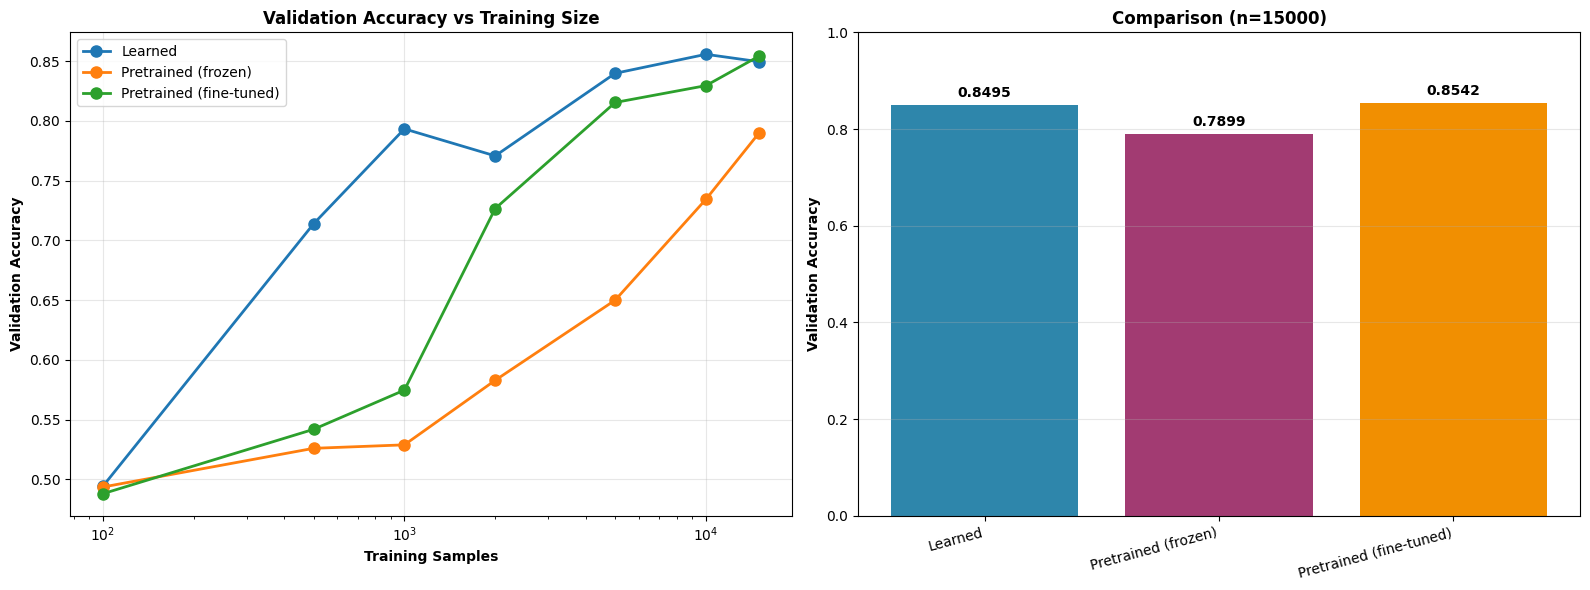

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Line plot
ax1 = axes[0]
for model_name in results_df['model'].unique():
    data = results_df[results_df['model'] == model_name]
    ax1.plot(data['n_samples'], data['val_accuracy'],
             marker='o', linewidth=2, markersize=8, label=model_name)

ax1.set_xlabel('Training Samples', fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontweight='bold')
ax1.set_title('Validation Accuracy vs Training Size', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Bar chart
ax2 = axes[1]
if len(results_df) > 0:
    latest = results_df[results_df['n_samples'] == results_df['n_samples'].max()]
    bars = ax2.bar(range(len(latest)), latest['val_accuracy'],
                   color=['#2E86AB', '#A23B72', '#F18F01'])
    ax2.set_ylabel('Validation Accuracy', fontweight='bold')
    ax2.set_title(f'Comparison (n={int(latest["n_samples"].max())})', fontweight='bold')
    ax2.set_xticks(range(len(latest)))
    ax2.set_xticklabels(latest['model'], rotation=15, ha='right')
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3, axis='y')

    for bar, acc in zip(bars, latest['val_accuracy']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('assignment4_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: assignment4_results.png")
plt.show()

In [12]:
# Save CSV
results_df.to_csv('assignment4_results.csv', index=False)
print(" Saved: assignment4_results.csv")

# Print conclusions

print("CONCLUSIONS")


if len(results_df) > 0:
    best = results_df.loc[results_df['val_accuracy'].idxmax()]
    print(f"\n Best model: {best['model']}")
    print(f"  Accuracy: {best['val_accuracy']:.4f}")
    print(f"  Training samples: {int(best['n_samples'])}")

    small = results_df[results_df['n_samples'] <= 500]
    if len(small) > 0:
        best_small = small.loc[small['val_accuracy'].idxmax()]
        print(f"\nBest with ≤500 samples: {best_small['model']}")
        print(f"  Accuracy: {best_small['val_accuracy']:.4f}")





 Saved: assignment4_results.csv
CONCLUSIONS

 Best model: Learned
  Accuracy: 0.8557
  Training samples: 10000

Best with ≤500 samples: Learned
  Accuracy: 0.7139
